# Load Libraries

In [2]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 

from sklearn.model_selection import GroupKFold
from sklearn.linear_model import LogisticRegression

from scipy.spatial.distance import pdist, squareform
from scipy.stats import pearsonr

import fnmatch
import os

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

C:\Users\19012\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


# Load Data

In [3]:
# load players.csv to identify players by their name
players = pd.read_csv("C:/Users/19012/Documents/BDB 2023/players.csv")

# load data to calculate distances from players on the field (and also the distance from the football)
scout = pd.read_csv("C:/Users/19012/Documents/BDB 2023/pffScoutingData.csv")
# data = pd.read_csv("C:/Users/19012/Documents/BDB 2023/week1.csv")
plays = pd.read_csv("C:/Users/19012/Documents/BDB 2023/plays.csv")

In [4]:
# load in the weekly tracking data
data = pd.DataFrame()

for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if fnmatch.fnmatch(f, '*week*.csv'):
        print(f)
        week = pd.read_csv(f)
        data = data.append(week)

NameError: name 'directory' is not defined

In [38]:
data.head()

,gameId,playId,nflId,frameId,time,jerseyNumber,team,playDirection,x,y,s,a,dis,o,dir,event
0,2021090900,97,25511.0,1,2021-09-10T00:26:31.100,12.0,TB,right,37.77,24.22,0.29,0.30,0.03,165.16,84.99,None
1,2021090900,97,25511.0,2,2021-09-10T00:26:31.200,12.0,TB,right,37.78,24.22,0.23,0.11,0.02,164.33,92.87,None
2,2021090900,97,25511.0,3,2021-09-10T00:26:31.300,12.0,TB,right,37.78,24.24,0.16,0.10,0.01,160.24,68.55,None
3,2021090900,97,25511.0,4,2021-09-10T00:26:31.400,12.0,TB,right,37.73,24.25,0.15,0.24,0.06,152.13,296.85,None
4,2021090900,97,25511.0,5,2021-09-10T00:26:31.500,12.0,TB,right,37.69,24.26,0.25,0.18,0.04,148.33,287.55,None


In [40]:
# merge scout data onto the tracking data 
data = data.merge(scout, how='left')

In [41]:
scout.pff_role.unique()

array(['Pass', 'Pass Route', 'Pass Block', 'Pass Rush', 'Coverage'],
      dtype=object)

In [42]:
players.head()

,nflId,height,weight,birthDate,collegeName,officialPosition,displayName
0,25511,6-4,225,1977-08-03,Michigan,QB,Tom Brady
1,28963,6-5,240,1982-03-02,"Miami, O.",QB,Ben Roethlisberger
2,29550,6-4,328,1982-01-22,Arkansas,T,Jason Peters
3,29851,6-2,225,1983-12-02,California,QB,Aaron Rodgers
4,30078,6-2,228,1982-11-24,Harvard,QB,Ryan Fitzpatrick


In [43]:
scout.head()

,gameId,playId,nflId,pff_role,pff_positionLinedUp,pff_hit,pff_hurry,pff_sack,pff_beatenByDefender,pff_hitAllowed,pff_hurryAllowed,pff_sackAllowed,pff_nflIdBlockedPlayer,pff_blockType,pff_backFieldBlock
0,2021090900,97,25511,Pass,QB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021090900,97,35481,Pass Route,TE-L,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021090900,97,35634,Pass Route,LWR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021090900,97,39985,Pass Route,HB-R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021090900,97,40151,Pass Block,C,NaN,NaN,NaN,0.0,0.0,0.0,0.0,44955.0,SW,0.0


In [44]:
plays.head()

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,yardlineSide,yardlineNumber,gameClock,preSnapHomeScore,preSnapVisitorScore,passResult,penaltyYards,prePenaltyPlayResult,playResult,foulName1,foulNFLId1,foulName2,foulNFLId2,foulName3,foulNFLId3,absoluteYardlineNumber,offenseFormation,personnelO,defendersInBox,personnelD,dropBackType,pff_playAction,pff_passCoverage,pff_passCoverageType
0,2021090900,97,(13:33) (Shotgun) T.Brady pass incomplete deep...,1,3,2,TB,DAL,TB,33,13:33,0,0,I,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,43.0,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0,Cover-1,Man
1,2021090900,137,(13:18) (Shotgun) D.Prescott pass deep left to...,1,1,10,DAL,TB,DAL,2,13:18,0,0,C,NaN,28,28,NaN,NaN,NaN,NaN,NaN,NaN,108.0,EMPTY,"1 RB, 2 TE, 2 WR",6.0,"4 DL, 4 LB, 3 DB",TRADITIONAL,0,Cover-3,Zone
2,2021090900,187,(12:23) (Shotgun) D.Prescott pass short middle...,1,2,6,DAL,TB,DAL,34,12:23,0,0,C,NaN,5,5,NaN,NaN,NaN,NaN,NaN,NaN,76.0,SHOTGUN,"0 RB, 2 TE, 3 WR",6.0,"3 DL, 3 LB, 5 DB",TRADITIONAL,0,Cover-3,Zone
3,2021090900,282,(9:56) D.Prescott pass incomplete deep left to...,1,1,10,DAL,TB,TB,39,09:56,0,0,I,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,49.0,SINGLEBACK,"1 RB, 2 TE, 2 WR",6.0,"4 DL, 3 LB, 4 DB",TRADITIONAL,1,Cover-3,Zone
4,2021090900,349,(9:46) (Shotgun) D.Prescott pass incomplete sh...,1,3,15,DAL,TB,TB,44,09:46,0,0,I,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,54.0,SHOTGUN,"1 RB, 1 TE, 3 WR",7.0,"3 DL, 4 LB, 4 DB",TRADITIONAL,0,Cover-3,Zone


In [45]:
data.head()

,gameId,playId,nflId,frameId,time,jerseyNumber,team,playDirection,x,y,s,a,dis,o,dir,event,pff_role,pff_positionLinedUp,pff_hit,pff_hurry,pff_sack,pff_beatenByDefender,pff_hitAllowed,pff_hurryAllowed,pff_sackAllowed,pff_nflIdBlockedPlayer,pff_blockType,pff_backFieldBlock
0,2021090900,97,25511.0,1,2021-09-10T00:26:31.100,12.0,TB,right,37.77,24.22,0.29,0.30,0.03,165.16,84.99,None,Pass,QB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021090900,97,25511.0,2,2021-09-10T00:26:31.200,12.0,TB,right,37.78,24.22,0.23,0.11,0.02,164.33,92.87,None,Pass,QB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021090900,97,25511.0,3,2021-09-10T00:26:31.300,12.0,TB,right,37.78,24.24,0.16,0.10,0.01,160.24,68.55,None,Pass,QB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021090900,97,25511.0,4,2021-09-10T00:26:31.400,12.0,TB,right,37.73,24.25,0.15,0.24,0.06,152.13,296.85,None,Pass,QB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021090900,97,25511.0,5,2021-09-10T00:26:31.500,12.0,TB,right,37.69,24.26,0.25,0.18,0.04,148.33,287.55,None,Pass,QB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
data.event.unique()

array(['None', 'ball_snap', 'autoevent_passforward', 'pass_forward',
       'autoevent_ballsnap', 'line_set', 'play_action', 'pass_arrived',
       'autoevent_passinterrupted', 'fumble', 'fumble_offense_recovered',
       'qb_sack', 'run', 'man_in_motion', 'pass_outcome_caught',
       'pass_outcome_incomplete', 'pass_tipped', 'qb_strip_sack', 'shift',
       'first_contact', 'huddle_break_offense', 'lateral', 'handoff',
       'penalty_flag', 'tackle', 'dropped_pass', 'out_of_bounds'],
      dtype=object)

In [47]:
data.pff_positionLinedUp.unique()

array(['QB', 'TE-L', 'LWR', 'HB-R', 'C', 'RWR', 'LEO', 'LT', 'ROLB', 'LG',
       'RCB', 'SLWR', 'SCBR', 'DRT', 'FS', 'RG', 'LILB', 'RT', 'LCB',
       'RE', nan, 'RLB', 'SCBoL', 'SRoWR', 'DLT', 'SRiWR', 'SCBiL', 'REO',
       'RILB', 'SSR', 'LLB', 'LE', 'LOLB', 'NLT', 'TE-oR', 'TE-iR', 'HB',
       'FSR', 'MLB', 'HB-L', 'TE-R', 'SRWR', 'SCBL', 'NT', 'FSL', 'SSL',
       'NRT', 'SS', 'SLoWR', 'SLiWR', 'SCBiR', 'SCBoR', 'TE-oL', 'TE-iL',
       'FB-L', 'FB', 'FB-R'], dtype=object)

# Data Preprocessing

We need to do multiple things before the data is usable. Those include:

- Create Larger Buckets

    - The code we use to find the nearest player on the other team creates columns with names corresponding to the player's position. Therefore, it will be easier to read with fewer positions.

- Normalize Data

    - Normalizing the data will make every offensive play move in the same direction which will be useful for modeling.

- Remove plays where the QB goes outside of the pocket

    - Plays can get crazy when the QB leaves the pocket; therefore, we will begin by just using plays where the QB does not leave the pocket.

## Create Larger Buckets

Create larger buckets to one-hot encode the positions into edge, interior, or LB.

In [48]:
# group positions into larger buckets
# data['position'] = np.where(data['pff_positionLinedUp'] in ['TE-L','TE-oR''TE-iR','TE-R','TE-oL','TE-iL','TE'])
conditions = [
    (data['pff_positionLinedUp'] == 'TE-L') | (data['pff_positionLinedUp'] == 'TE-oR') | (data['pff_positionLinedUp'] == 'TE-iR') | (data['pff_positionLinedUp'] == 'TE-R') | (data['pff_positionLinedUp'] == 'TE-oL') | (data['pff_positionLinedUp'] == 'TE-iL') | (data['pff_positionLinedUp'] == 'TE'),
    (data['pff_positionLinedUp'] == 'LWR') | (data['pff_positionLinedUp'] == 'RWR') | (data['pff_positionLinedUp'] == 'SLWR') | (data['pff_positionLinedUp'] == 'SRoWR') | (data['pff_positionLinedUp'] == 'SRiWR') | (data['pff_positionLinedUp'] == 'SRWR') | (data['pff_positionLinedUp'] == 'SLoWR') | (data['pff_positionLinedUp'] == 'SLiWR') | (data['pff_positionLinedUp'] == 'WR'),
    (data['pff_positionLinedUp'] == 'HB-R') | (data['pff_positionLinedUp'] == 'HB') | (data['pff_positionLinedUp'] == 'HB-L'),
    (data['pff_positionLinedUp'] == 'C'),
    (data['pff_positionLinedUp'] == 'LEO') | (data['pff_positionLinedUp'] == 'LE') | (data['pff_positionLinedUp'] == 'RE') | (data['pff_positionLinedUp'] == 'REO'),
    (data['pff_positionLinedUp'] == 'LT') | (data['pff_positionLinedUp'] == 'RT'),
    (data['pff_positionLinedUp'] == 'ROLB') | (data['pff_positionLinedUp'] == 'RLB') | (data['pff_positionLinedUp'] == 'RILB') | (data['pff_positionLinedUp'] == 'LILB') | (data['pff_positionLinedUp'] == 'LLB') | (data['pff_positionLinedUp'] == 'LOLB') | (data['pff_positionLinedUp'] == 'LEO') | (data['pff_positionLinedUp'] == 'MLB'),
    (data['pff_positionLinedUp'] == 'LG') | (data['pff_positionLinedUp'] == 'RG'),
    (data['pff_positionLinedUp'] == 'RCB') | (data['pff_positionLinedUp'] == 'SCBR') | (data['pff_positionLinedUp'] == 'LCB') | (data['pff_positionLinedUp'] == 'SCBoL') | (data['pff_positionLinedUp'] == 'SCBiL') | (data['pff_positionLinedUp'] == 'SCBL') | (data['pff_positionLinedUp'] == 'SCBiR') | (data['pff_positionLinedUp'] == 'SCBoR'),
    (data['pff_positionLinedUp'] == 'DRT') | (data['pff_positionLinedUp'] == 'DLT') | (data['pff_positionLinedUp'] == 'DT'),
    (data['pff_positionLinedUp'] == 'FS') | (data['pff_positionLinedUp'] == 'FSR') | (data['pff_positionLinedUp'] == 'FSL'),
    (data['pff_positionLinedUp'] == 'SSR') | (data['pff_positionLinedUp'] == 'SS') | (data['pff_positionLinedUp'] == 'SSL'),
    (data['pff_positionLinedUp'] == 'NLT') | (data['pff_positionLinedUp'] == 'NRT') | (data['pff_positionLinedUp'] == 'NT'),
    (data['pff_positionLinedUp'] == 'FB-L') | (data['pff_positionLinedUp'] == 'FB') | (data['pff_positionLinedUp'] == 'FB-R')
]
choices = ['TE', 'WR', 'HB', 'C', 'DE', 'T', 'LB', 'G', 'CB', 'DT', 'FS', 'SS', 'NT', 'FB']
data['position'] = np.select(conditions, choices, default=np.nan)

In [49]:
# sannity check
# data.position.unique()

## Normalize Data

Get all players moving in the same direction for offense (left) and defense (right).

In [50]:
data = data.merge(plays, how='left')
data.head()

,gameId,playId,nflId,frameId,time,jerseyNumber,team,playDirection,x,y,s,a,dis,o,dir,event,pff_role,pff_positionLinedUp,pff_hit,pff_hurry,pff_sack,pff_beatenByDefender,pff_hitAllowed,pff_hurryAllowed,pff_sackAllowed,pff_nflIdBlockedPlayer,pff_blockType,pff_backFieldBlock,position,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,yardlineSide,yardlineNumber,gameClock,preSnapHomeScore,preSnapVisitorScore,passResult,penaltyYards,prePenaltyPlayResult,playResult,foulName1,foulNFLId1,foulName2,foulNFLId2,foulName3,foulNFLId3,absoluteYardlineNumber,offenseFormation,personnelO,defendersInBox,personnelD,dropBackType,pff_playAction,pff_passCoverage,pff_passCoverageType
0,2021090900,97,25511.0,1,2021-09-10T00:26:31.100,12.0,TB,right,37.77,24.22,0.29,0.30,0.03,165.16,84.99,None,Pass,QB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,(13:33) (Shotgun) T.Brady pass incomplete deep...,1,3,2,TB,DAL,TB,33,13:33,0,0,I,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,43.0,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0,Cover-1,Man
1,2021090900,97,25511.0,2,2021-09-10T00:26:31.200,12.0,TB,right,37.78,24.22,0.23,0.11,0.02,164.33,92.87,None,Pass,QB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,(13:33) (Shotgun) T.Brady pass incomplete deep...,1,3,2,TB,DAL,TB,33,13:33,0,0,I,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,43.0,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0,Cover-1,Man
2,2021090900,97,25511.0,3,2021-09-10T00:26:31.300,12.0,TB,right,37.78,24.24,0.16,0.10,0.01,160.24,68.55,None,Pass,QB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,(13:33) (Shotgun) T.Brady pass incomplete deep...,1,3,2,TB,DAL,TB,33,13:33,0,0,I,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,43.0,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0,Cover-1,Man
3,2021090900,97,25511.0,4,2021-09-10T00:26:31.400,12.0,TB,right,37.73,24.25,0.15,0.24,0.06,152.13,296.85,None,Pass,QB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,(13:33) (Shotgun) T.Brady pass incomplete deep...,1,3,2,TB,DAL,TB,33,13:33,0,0,I,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,43.0,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0,Cover-1,Man
4,2021090900,97,25511.0,5,2021-09-10T00:26:31.500,12.0,TB,right,37.69,24.26,0.25,0.18,0.04,148.33,287.55,None,Pass,QB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,(13:33) (Shotgun) T.Brady pass incomplete deep...,1,3,2,TB,DAL,TB,33,13:33,0,0,I,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,43.0,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0,Cover-1,Man


In [51]:
# normalize data
data['isOnOffense'] = data['team']==data['possessionTeam']
data['ToLeft'] = data['playDirection']=='left'
data['X_std'] = np.where(data['ToLeft']==True, 120-data['x'],data['x'])
data['Y_std'] = np.where(data['ToLeft']==True, 160/3-data['y'],data['y'])

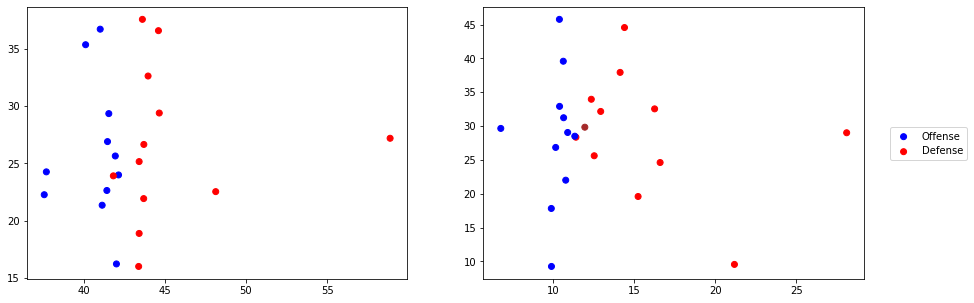

In [52]:
# sanity check
fig, axs = plt.subplots(1,2,figsize=(15, 5))

directionCheck = data[(data['gameId']==2021090900) & (data['playId']==97) & (data['frameId']==5)]
colors = {True:'blue',False:'red','football':'brown'}
axs[0].scatter(directionCheck['X_std'], directionCheck['Y_std'], c=directionCheck['isOnOffense'].map(colors))

directionCheck = data[(data['gameId']==2021090900) & (data['playId']==137) & (data['frameId']==5)]
colors = {'DAL':'blue','TB':'red','football':'brown'}
axs[1].scatter(directionCheck['X_std'], directionCheck['Y_std'], c=directionCheck['team'].map(colors))

fig.legend(('Offense', 'Defense','Ball'),loc="right",bbox_to_anchor=(1, 0.5))
plt.show()

Looks like our normalization worked as the play direction in the second image is to the left but the team with the ball is now moving right.

## Remove any play where the QB exits the pocket

In [53]:
# determine pocket
# might not need this
pocket = data[(data['team']=='football') & (data['event']=='ball_snap')].copy()
pocket['back'] = pocket['X_std']-5
pocket['left'] = pocket['Y_std']+7
pocket['right'] = pocket['Y_std']-7

data = data.merge(pocket[['gameId','playId','back', 'left','right']],how='left',on=['gameId','playId'])
data.head()

,gameId,playId,nflId,frameId,time,jerseyNumber,team,playDirection,x,y,s,a,dis,o,dir,event,pff_role,pff_positionLinedUp,pff_hit,pff_hurry,pff_sack,pff_beatenByDefender,pff_hitAllowed,pff_hurryAllowed,pff_sackAllowed,pff_nflIdBlockedPlayer,pff_blockType,pff_backFieldBlock,position,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,yardlineSide,yardlineNumber,gameClock,preSnapHomeScore,preSnapVisitorScore,passResult,penaltyYards,prePenaltyPlayResult,playResult,foulName1,foulNFLId1,foulName2,foulNFLId2,foulName3,foulNFLId3,absoluteYardlineNumber,offenseFormation,personnelO,defendersInBox,personnelD,dropBackType,pff_playAction,pff_passCoverage,pff_passCoverageType,isOnOffense,ToLeft,X_std,Y_std,back,left,right
0,2021090900,97,25511.0,1,2021-09-10T00:26:31.100,12.0,TB,right,37.77,24.22,0.29,0.30,0.03,165.16,84.99,None,Pass,QB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,(13:33) (Shotgun) T.Brady pass incomplete deep...,1,3,2,TB,DAL,TB,33,13:33,0,0,I,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,43.0,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0,Cover-1,Man,True,False,37.77,24.22,36.56,30.92,16.92
1,2021090900,97,25511.0,2,2021-09-10T00:26:31.200,12.0,TB,right,37.78,24.22,0.23,0.11,0.02,164.33,92.87,None,Pass,QB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,(13:33) (Shotgun) T.Brady pass incomplete deep...,1,3,2,TB,DAL,TB,33,13:33,0,0,I,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,43.0,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0,Cover-1,Man,True,False,37.78,24.22,36.56,30.92,16.92
2,2021090900,97,25511.0,3,2021-09-10T00:26:31.300,12.0,TB,right,37.78,24.24,0.16,0.10,0.01,160.24,68.55,None,Pass,QB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,(13:33) (Shotgun) T.Brady pass incomplete deep...,1,3,2,TB,DAL,TB,33,13:33,0,0,I,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,43.0,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0,Cover-1,Man,True,False,37.78,24.24,36.56,30.92,16.92
3,2021090900,97,25511.0,4,2021-09-10T00:26:31.400,12.0,TB,right,37.73,24.25,0.15,0.24,0.06,152.13,296.85,None,Pass,QB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,(13:33) (Shotgun) T.Brady pass incomplete deep...,1,3,2,TB,DAL,TB,33,13:33,0,0,I,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,43.0,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0,Cover-1,Man,True,False,37.73,24.25,36.56,30.92,16.92
4,2021090900,97,25511.0,5,2021-09-10T00:26:31.500,12.0,TB,right,37.69,24.26,0.25,0.18,0.04,148.33,287.55,None,Pass,QB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,(13:33) (Shotgun) T.Brady pass incomplete deep...,1,3,2,TB,DAL,TB,33,13:33,0,0,I,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,43.0,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0,Cover-1,Man,True,False,37.69,24.26,36.56,30.92,16.92


In [54]:
data['dropBackType'].unique()

array(['TRADITIONAL', 'SCRAMBLE_ROLLOUT_RIGHT', 'DESIGNED_ROLLOUT_RIGHT',
       nan, 'SCRAMBLE', 'DESIGNED_ROLLOUT_LEFT', 'UNKNOWN',
       'DESIGNED_RUN', 'SCRAMBLE_ROLLOUT_LEFT'], dtype=object)

In [55]:
# just assume traditional dropback without any identification of rollout means the QB stayed in the pocket
data = data[data['dropBackType']=='TRADITIONAL']
data = data.reset_index()

In [56]:
# capture the indices which are included between ball snap and pass/sack/strip sack 
recordBool = False
recordArray = []
for i in range(data.index[0],data.index[-1]):
    if data['event'][i] == 'ball_snap':
        recordBool = True
    elif (data['event'][i] == 'pass_forward') | (data['event'][i] == 'qb_sack') | (data['event'][i] == 'qb_strip_sack'):
        recordBool = False
        recordArray.append(i)
    if recordBool == True:
        recordArray.append(i)

In [57]:
data = data.loc[recordArray]

In [58]:
# write to csv to use later
data.to_csv("C:/Users/19012/Documents/BDB 2023/frame_filter_df.csv")